In [2]:
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

q_table = None
env = gym.make("FrozenLake8x8-v1", is_slippery=True, render_mode="human")





## Reinforcement Learning

The **reinforcement learning** is a paradigm of machine learning that often relies on the interaction of **agent** and **environment**.


This is a diagram of the **Markov Decision Process**, which is the best friend of RL and probabilistic decision-making models in general. We'll refer to it as **MDP** for short.

---

### MDP

The **MDP** is described with:
- **States**: all possible states the agent could encounter, $s \in \mathcal{S}$
- **Actions**: set of possible actions, $a \in \mathcal{A}(s)$, for every state
- **Rewards**: set of rewards for $r = R(s) \in \mathbb{R}$, meaning all states have some reward (or none)

---

Also, to explain the main idea of the MDP, we should have **discrete time steps**:
$$ t \in \{0, 1, 2, \dots, n\}$$

MDP has an assumption that **previous steps don't affect the underlying probability distribution**, then it looks like:

$$
p(s', r \mid s, a)
$$

MDP defines the probability of getting new state $s'$ and receiving reward $r$ after taking action $a$ in state $s$.

MDP describes the **environment**, and the **agent** behavior is described within **policy**.

---

## Policy $\pi$

Policy $\pi(a \mid s)$ tells the **probability of taking a particular action** $a$ among $\mathcal{A}(s)$ when being in state $s$.

---

## Return $G_t$

Now we have defined the environment and agent and could even test the setup.

For this test, the authors (of the setup) follow the **uniform distribution** — this is called the **random policy**.

Now the agent is performing **random actions**, completing the **SARSA loop**, but now it is practically useless.
We need to introduce the way to **improve policy**.

---

### Return $G_t$

The return $G_t$ is **accumulated rewards over all future time steps**.
Also, we want to consider **closer rewards as more valuable** — for that, we add **discount factor** $\gamma$, so:

$$
G_t = \sum_{k=t+1}^{T} \gamma^{k - t - 1} R_k
$$

---

With the idea of return formalized, the **goal for optimal policy** might be described as **maximizing expected return**:

$$
\pi^* = \arg\max_{\pi} \mathbb{E}_\pi [G_t]
$$

---

Let me know if you'd like this exported as a `.md` file or need it translated to another format like PDF or LaTeX source.

In [48]:
def run(q_table, episodes = 1, is_slippery = True):
    pygame.init()
    env = gym.make("FrozenLake8x8-v1", is_slippery=is_slippery, render_mode="human")
    policy = q_table

    action_map = {
        0: "LEFT",
        1: "DOWN",
        2: "RIGHT",
        3: "UP"
    }

    for i in range(episodes):
        state = env.reset()[0]
        print(f"Initial state is [{state // 8}, {state % 8}]")
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action_space = policy[state]
            action = np.argmax(action_space)
            print(f"Action is [{action}]")
            print(f"Action is {action_map[action]}]")
            new_state, reward, terminated, truncated,_ = env.step(action)

            state = new_state

            print(f"New state is [{new_state // 8}, {new_state % 8}], reward is {reward}")

    env.close()

    pygame.quit()

run(q_table, episodes=1, is_slippery=False)

Initial state is [0, 0]
Action is [1]
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is [1]
Action is DOWN]
New state is [2, 0], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [2, 1], reward is 0.0
Action is [2]
Action is RIGHT]
New state is [2, 2], reward is 0.0
Action is [1]
Action is DOWN]


KeyboardInterrupt: 

In [4]:
q_random = np.random.rand(env.observation_space.n, env.action_space.n)

run(q_random ,episodes = 1)

2025-03-30 21:57:01.211 python[6207:13051116] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-30 21:57:01.211 python[6207:13051116] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Initial state is [0, 0]
Action is DOWN]
New state is [0, 1], reward is 0.0
Action is DOWN]
New state is [1, 1], reward is 0.0
Action is DOWN]
New state is [1, 2], reward is 0.0
Action is DOWN]
New state is [1, 1], reward is 0.0
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is DOWN]
New state is [1, 0], reward is 0.0
Action is DOWN]
New state is [2, 0], reward is 0.0
Action is DOWN]
New state is [2, 0], reward is 0.0
Action is DOWN]
New state is [2, 0], reward is 0.0
Action is DOWN]
New state is [3, 0], reward is 0.0
Action is DOWN]
New state is [3, 1], reward is 0.0
Action is DOWN]
New state is [4, 1], reward is 0.0
Action is DOWN]
New state is [4, 0], reward is 0.0
Action is DOWN]
New state is [5, 0], reward is 0.0
Action is DOWN]
New state is [5, 1], reward is 0.0


In [5]:
def train(
        episodes=4000,
        lr=1e-2,
        gamma=0.9,
        td_num=4,
        cost_of_living=0.01,
        T=100,
        render=False,
        isSlippery=True,
        label="base"):

    pygame.init()
    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery=isSlippery, render_mode='human' if render else None)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    success_rate = np.zeros(episodes)
    steps_per_episode = []

    for episode in range(episodes):
        trajectory = []
        state = env.reset()[0]
        steps = 0
        total_reward = 0

        for t in range(T):
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            new_state, reward, terminated, truncated, _ = env.step(action)
            steps += 1

            # Adjust reward for falling into a hole
            if (terminated) and (reward == 0):
                reward = reward - 1

            if reward == 1:
                success_rate[episode] = 1.0
                time_rewards_per_episode[episode] = 1
                steps_per_episode.append(steps)
                reward = reward - cost_of_living * steps

            reward -= cost_of_living

            total_reward += reward

            # Store transition with termination info
            trajectory.append((state, action, reward, new_state, terminated))

            # Process n-step updates
            while len(trajectory) >= td_num:
                # Pop the oldest transition
                oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated = trajectory.pop(0)

                G = oldest_reward
                current_gamma = gamma
                term_in_window = oldest_terminated

                # Sum rewards for next (td_num-1) steps or until termination
                for k in range(1, td_num):
                    if (k-1) >= len(trajectory):
                        break
                    entry = trajectory[k-1]
                    r_k, term_k = entry[2], entry[4]
                    G += current_gamma * r_k
                    current_gamma *= gamma
                    if term_k:
                        term_in_window = True
                        break

                # Add discounted Q-value if no termination in the window
                if not term_in_window and len(trajectory) >= (td_num-1):
                    last_entry = trajectory[td_num-2]  if td_num != 1 else (oldest_state, oldest_action, oldest_reward, oldest_new_state, oldest_terminated)
                    last_state = last_entry[3]
                    if not last_entry[4]:
                        G += current_gamma * np.max(q_table[last_state])

                # Update Q-value
                q_table[oldest_state][oldest_action] += lr * (G - q_table[oldest_state][oldest_action])

            state = new_state
            if terminated or truncated:
                break

        # Process remaining transitions after episode ends
        while len(trajectory) > 0:

            if trajectory[-1][3] == 0.99:
                print("a")

            oldest_entry = trajectory.pop(0)
            s, a, r, s_new, term = oldest_entry

            G = r
            current_gamma = gamma

            for k in range(1, len(trajectory)+1):
                if (k-1) >= len(trajectory):
                    break
                entry = trajectory[k-1]
                r_k, term_k = entry[2], entry[4]
                G += current_gamma * r_k
                current_gamma *= gamma

            # No Q-value added after episode termination
            q_table[s][a] += lr * (G - q_table[s][a])

        # Decay exploration and learning rate
        epsilon = max(epsilon - epsilon_decay, 0)
        rewards_per_episode[episode] = total_reward
        # if epsilon == 0:
        #     lr *= 0.1  # Decay learning rate after exploration stops

        print(f"Episode {episode} | Reward: {rewards_per_episode[episode]} | Epsilon: {epsilon}")

    env.close()
    pygame.quit()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)

    moving_average_window = episodes // 10
    moving_averages = savgol_filter(rewards_per_episode * 100, moving_average_window, 5)

    plt.plot(moving_averages, label=f'{label}')
    plt.title(label)
    plt.legend()

    print("__________________________________")
    print(f"{label}")
    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode)*0.9):])
    mean_success_rate = np.mean(success_rate[int(len(success_rate)*0.9):])
    print(f"Mean reward: {mean_reward_rate}")
    print(f"Mean success rate: {mean_success_rate}")
    if steps_per_episode:
        mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode)*0.9):])
        print(f"Mean steps per success episode: {mean_steps}")
    else:
        print("No successful episodes to calculate mean steps.")

firstly test if the train function is working properly

Episode 0 | Reward: -1.17 | Epsilon: 0.9997222222222222
Episode 1 | Reward: -1.21 | Epsilon: 0.9994444444444444
Episode 2 | Reward: -1.18 | Epsilon: 0.9991666666666665
Episode 3 | Reward: -1.13 | Epsilon: 0.9988888888888887
Episode 4 | Reward: -1.26 | Epsilon: 0.9986111111111109
Episode 5 | Reward: -1.06 | Epsilon: 0.9983333333333331
Episode 6 | Reward: -1.09 | Epsilon: 0.9980555555555553
Episode 7 | Reward: -1.19 | Epsilon: 0.9977777777777774
Episode 8 | Reward: -1.08 | Epsilon: 0.9974999999999996
Episode 9 | Reward: -1.4800000000000002 | Epsilon: 0.9972222222222218
Episode 10 | Reward: -1.09 | Epsilon: 0.996944444444444
Episode 11 | Reward: -1.5900000000000003 | Epsilon: 0.9966666666666661
Episode 12 | Reward: -1.5400000000000003 | Epsilon: 0.9963888888888883
Episode 13 | Reward: -1.4800000000000002 | Epsilon: 0.9961111111111105
Episode 14 | Reward: -1.4900000000000002 | Epsilon: 0.9958333333333327
Episode 15 | Reward: -1.6100000000000003 | Epsilon: 0.9955555555555549
Episode 16 | Re

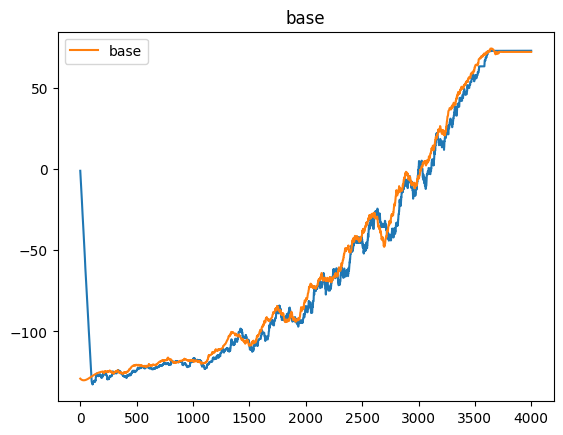

In [35]:
train(episodes=4000, td_num=1, lr=0.1, isSlippery=False)

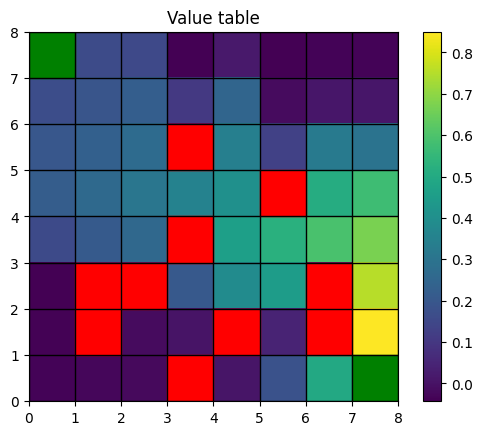

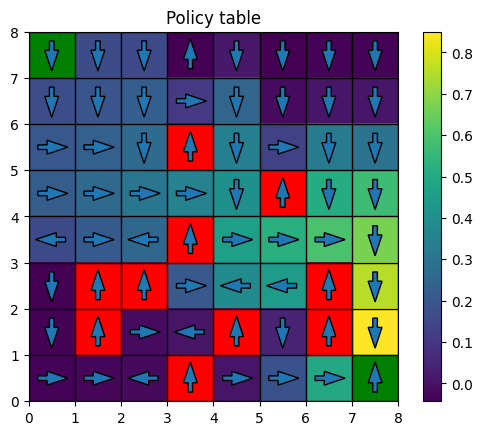

In [60]:
def plot_q_table(q_table):
    values = q_table.max(axis=1)
    values_grid = values.reshape(8,8)

    plt.imshow(
        values_grid,
        origin='upper',
        extent=[0, 8, 0, 8],
        interpolation='nearest',
        aspect='equal'
    )
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

    holes = [(5,3), (3,3), (4,5),(2,2), (2,1), (1,1), (0,3), (1,4), (1,6), (2,6)]

    ax = plt.gca()
    for (row, col) in holes:
        rect = plt.Rectangle(
                (col, row),
                1, 1,
                fill=True,
                color='red',
                alpha=1
            )
        ax.add_patch(rect)

    rect = plt.Rectangle(
                (7, 0),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    rect = plt.Rectangle(
                (0, 7),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    plt.title("Value table")
    plt.colorbar()
    plt.show()




    actions = q_table.argmax(axis=1)

    actions_grid = actions.reshape(8,8)

    plt.imshow(
        values_grid,
        origin='upper',
        extent=[0, 8, 0, 8],
        interpolation='nearest',
        aspect='equal'
    )
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)

    holes = [(5,3), (3,3), (4,5),(2,2), (2,1), (1,1), (0,3), (1,4), (1,6), (2,6)]

    ax = plt.gca()
    for (row, col) in holes:
        rect = plt.Rectangle(
                (col, row),
                1, 1,
                fill=True,
                color='red',
                alpha=1
            )
        ax.add_patch(rect)

    rect = plt.Rectangle(
                (7, 0),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    rect = plt.Rectangle(
                (0, 7),
                1, 1,
                fill=True,
                color='green',
                alpha=1
            )
    ax.add_patch(rect)

    for y in range(8):
        for x in range(8):
            # (0,0)  (y,x)-> (0, 7)(x, 7 - y)

            action = actions_grid[y, x]

            match action:
                case 0:
                    # top
                    start_y, start_x ,arrow_x, arrow_y = 0.2, 0.5, 0 , 0.2
                case 1:
                    # bot
                    start_y, start_x ,arrow_x, arrow_y = 0.8, 0.5, 0 , -0.2
                case 2:
                    # right
                    start_y, start_x ,arrow_x, arrow_y = 0.5, 0.2 , 0.2 , 0
                case 3:
                    # left
                    start_y, start_x ,arrow_x, arrow_y = 0.5, 0.8 , -0.2 , 0
                case _:
                    print("Unknown action")


            plt.arrow(x + start_x, 7 - y + start_y, arrow_x, arrow_y, width = 0.1)

    plt.title("Policy table")
    plt.colorbar()
    plt.show()


plot_q_table(q_table)

In [41]:
run(q_table, episodes=1, is_slippery=False)

Initial state is [0, 0]


AxisError: axis 1 is out of bounds for array of dimension 1

In [42]:
q_table

array([[ 1.11964746e-01,  1.41477254e-01,  1.32311654e-01,
         1.11223604e-01],
       [ 7.99225554e-02,  1.60474365e-01,  5.83718929e-02,
         8.24704904e-02],
       [-2.73275263e-02,  1.54434758e-01, -5.41583670e-02,
        -4.77685243e-02],
       [-4.13297247e-02, -4.38870004e-02, -4.78612431e-02,
        -5.52388229e-02],
       [-5.33486267e-02,  1.86688456e-02, -4.68935972e-02,
        -5.02385432e-02],
       [-4.60570175e-02, -4.04721849e-02, -4.24746252e-02,
        -4.28351769e-02],
       [-4.05114553e-02, -3.59571758e-02, -3.79407018e-02,
        -3.88941426e-02],
       [-3.66140508e-02, -3.41342298e-02, -3.61841740e-02,
        -3.66747628e-02],
       [ 1.35420775e-01,  1.68308060e-01,  1.59889751e-01,
         1.10407434e-01],
       [ 1.20023979e-01,  1.93273666e-01,  1.75644020e-01,
         1.14293589e-01],
       [ 9.46245083e-02,  2.22291923e-01,  6.13054233e-03,
         5.89618409e-02],
       [-4.05716337e-03, -1.00999990e+00,  1.06639839e-01,
      

__________________________________
LR 0.0001
Mean reward rate: 0.0
Mean steps per success episode: 71.0
__________________________________
LR 0.01
Mean reward rate: 0.045
Mean steps per success episode: 68.33333333333333
__________________________________
LR 0.1
Mean reward rate: 0.555
Mean steps per success episode: 63.233333333333334
__________________________________
LR 0.5
Mean reward rate: 0.39
Mean steps per success episode: 63.05882352941177


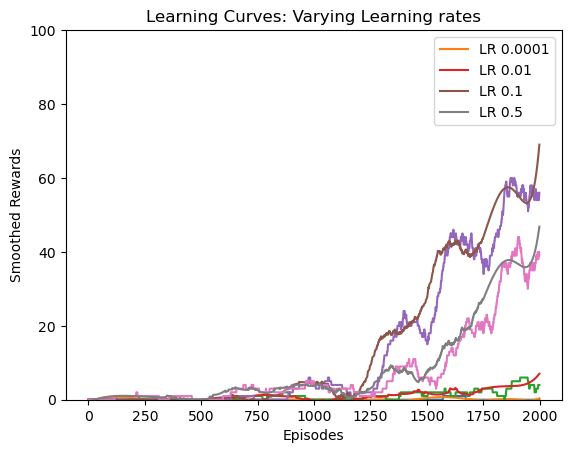

In [13]:
train(episodes=2000, learning_rate=0.0001, label="LR 0.0001")
train(episodes=2000, learning_rate=0.01, label="LR 0.01")
train(episodes=2000, learning_rate=0.1, label="LR 0.1")
train(episodes=2000, learning_rate=0.5, label="LR 0.5")

plt.title("Learning Curves: Varying Learning rates")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()


__________________________________
DF 0.99
Mean reward rate: 0.517
Mean steps per success episode: 66.1063829787234
__________________________________
DF 0.2
Mean reward rate: 0.267
Mean steps per success episode: 66.10759493670886


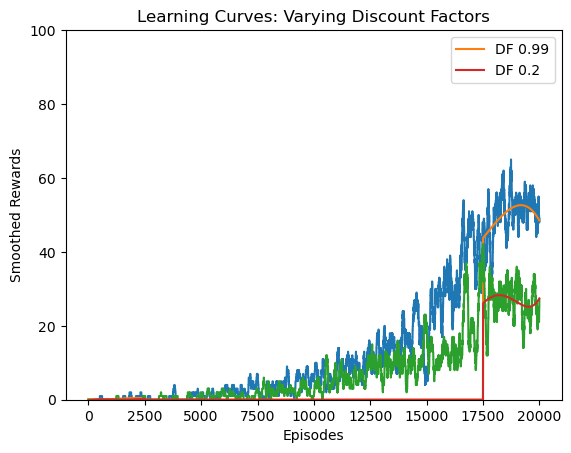

In [14]:
# Different Discount Factors
train(episodes=20000, discount_factor=0.99, label="DF 0.99")
train(episodes=20000, discount_factor=0.2, label="DF 0.2")

plt.title("Learning Curves: Varying Discount Factors")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()

__________________________________
10000 episodes
Mean reward rate: 0.428
Mean steps per success episode: 66.49557522123894
__________________________________
20000 episodes
Mean reward rate: 0.58
Mean steps per success episode: 63.181268882175225
__________________________________
40000 episodes
Mean reward rate: 0.5945
Mean steps per success episode: 63.80209895052474
__________________________________
100000 episodes
Mean reward rate: 0.5479
Mean steps per success episode: 64.19646125686394


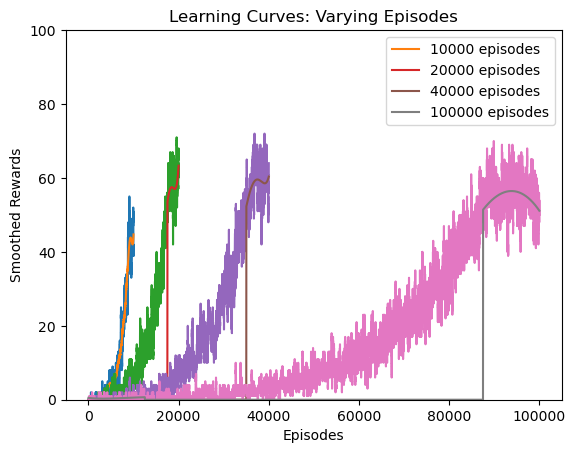

In [15]:
train(episodes=10000, learning_rate=0.01, label="10000 episodes")

train(episodes=20000, learning_rate=0.01, label="20000 episodes")

train(episodes=40000, learning_rate=0.01, label="40000 episodes")

train(episodes=100000, learning_rate=0.01, label="100000 episodes")

plt.title("Learning Curves: Varying Episodes")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()
